<a href="https://colab.research.google.com/github/AdamAnderB/CMUsic_HDDM/blob/main/HDDM_CMUsic_full_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In Tune with Language:
##Hierarchical Drift Diffusion Modeling of non-native Speech Discrimination


### Background

The environment that we experience is constantly changing. For language users and learners some of these changes take the form of variable noise in speech, new accents, unknown words, novel speech dimensions, and new concepts. To deal with this constantly adapting environment, language users must adapt their current knowledge to the new input. The systems that underpin this learning and adaptation are learning mechanisms. Over the last few years, increased music experience has repeatedly been suggest to positively influence a learners ability to acquire a new language.

One compelling facet influencing the adaptability of language users is their ability to discriminate speech segments. For this reason, musical experience has been suggested to have a profound impact on the cognitive processes that underpin language learning and adaptation. The intersection of music and language, allows us to start an exploration of whether musical expertise can shape the decision-making processes involved in non-native speech perception. Here, hierarchical drift diffusion modeling is used to explore the decision making process of two language tasks, a Mandarin ax and Japanese ax decision task, are the focus of study. Mandarin and Japanese were chosen because of their linguistic characteristics. In the case of Mandarin, Mandarin was used to explore the specific role of pitch as Mandarin uses pitch for lexical contrastiveness (e.g., 4 tones). On the otherhand, Japanese was chosen because of the geminate and non-geminate qualities of the segments. Specifically, Japanese uses contrastive duration to distinguish word meaning.

Here, I will use the accuracy of two sub-music skill tasks to explore the effects that music experience has on the decision making processes in non-native speech perception. Specifically, a relative pitch task and a rhythm task are used. In the pitch task a series 9 notes are played. After each series is played, participants must then select the pattern of notes played. All patterns start with a middle note. For rhythm, a similar task is performed. Participants hear a series of beats then must use a space bar to repeat the pattern. For both tasks, accuraccy is calculated by item and averaged across trials.


###The Modeling
####loading evnironment

In [1]:
!pip install numpy==1.23.4
!pip install git+https://github.com/lnccbrown/hssm@main
!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
!pip install numpyro

  Cloning https://github.com/lnccbrown/hssm (to revision main) to /tmp/pip-req-build-zgoua0o4
  Running command git clone --filter=blob:none --quiet https://github.com/lnccbrown/hssm /tmp/pip-req-build-zgoua0o4
  Resolved https://github.com/lnccbrown/hssm to commit de4898497b26f1ddcba99e9c41e3415ff30d360a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/brown-ccv/hddm-wfpt (to revision main) to /tmp/pip-req-build-mpbgkh33
  Running command git clone --filter=blob:none --quiet https://github.com/brown-ccv/hddm-wfpt /tmp/pip-req-build-mpbgkh33
  Resolved https://github.com/brown-ccv/hddm-wfpt to commit 523ac6ed09cc447c6b5f08b60a59db43520c4c57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


####Packages


In [2]:
from ssms.basic_simulators import simulator
import numpy as np
import pandas as pd

# Basics
import os
import sys
import time
import jax

from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

from jax.config import config

jax.config.update("jax_enable_x64", False)

<ipython-input-2-50989e87e558>:23: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


####data preperation

In [3]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_name)
df.head()


Saving sp_24_HDDM_music_data.csv to sp_24_HDDM_music_data (1).csv


,Unnamed: 0,Participant.Private.ID,Trial.Number,Spreadsheet.Name,Reaction.Time,rt_correct,Answer_correct,melody_score,beat_score,centered_beats,centered_melody
0,1,9353724,1,Mandarin,318.0,318.0,1,1.0,0.966667,0.649675,0.655506
1,2,9353724,2,Mandarin,369.0,369.0,1,1.0,0.966667,0.649675,0.655506
2,3,9353724,3,Mandarin,339.0,339.0,1,1.0,0.966667,0.649675,0.655506
3,4,9353724,4,Mandarin,609.0,609.0,1,1.0,0.966667,0.649675,0.655506
4,5,9353724,5,Mandarin,450.0,450.0,1,1.0,0.966667,0.649675,0.655506


#### Basic model data

In [4]:

##basic data frames
#adduseful columns
df['rt'] = df['Reaction.Time']
df['response'] = df['Answer_correct']
df['response'] = df['response'].replace({0: -1})

#create Mandarin df
df_mandarin = df[df['Spreadsheet.Name'] == 'Mandarin']
df_mandarin = df_mandarin[['rt', 'response']]
#df_mandarin.head()

#create Japanese df
df_japanese = df[df['Spreadsheet.Name'] == 'japanese']
df_japanese = df_japanese[['rt', 'response']]
#df_japanese.head()

# Display the updated DataFrame
print(df_mandarin.head())
print(df_japanese.head())

      rt  response
0  318.0         1
1  369.0         1
2  339.0         1
3  609.0         1
4  450.0         1
         rt  response
5196  835.0         1
5197  369.0         1
5198  297.0         1
5199  265.0         1
5200  341.0         1


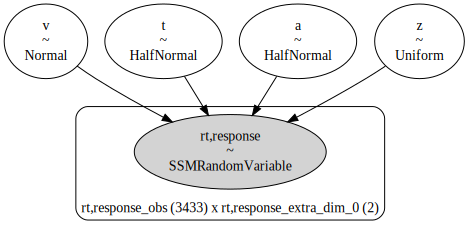

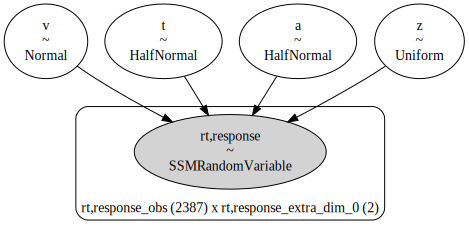

In [5]:
simple_ddm_model_mandarin = hssm.HSSM(data=df_mandarin)
simple_ddm_model_japanese = hssm.HSSM(data=df_japanese)

display(simple_ddm_model_mandarin.graph())
display(simple_ddm_model_japanese.graph())

In [6]:
#Basic Mandarin_model
infer_data_simple_ddm_model_mandarin = simple_ddm_model_mandarin.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=2,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [7]:
type(infer_data_simple_ddm_model_mandarin)
infer_data_simple_ddm_model_mandarin
az.summary(infer_data_simple_ddm_model_mandarin)

a_values = infer_data_simple_ddm_model_mandarin.posterior['a'].values
v_values = infer_data_simple_ddm_model_mandarin.posterior['v'].values
z_values = infer_data_simple_ddm_model_mandarin.posterior['z'].values
t_values = infer_data_simple_ddm_model_mandarin.posterior['t'].values

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [8]:
az.summary(infer_data_simple_ddm_model_mandarin)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.051,0.001,0.049,0.053,0.000,0.000,884.0,847.0,1.0
z,0.503,0.006,0.492,0.515,0.000,0.000,446.0,455.0,1.0
t,0.051,0.050,0.000,0.142,0.002,0.002,362.0,270.0,1.0
a,22.722,0.199,22.357,23.104,0.008,0.006,629.0,643.0,1.0


In [11]:
#Japanese_model
infer_data_simple_ddm_model_japanese = simple_ddm_model_japanese.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=2,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [12]:
type(infer_data_simple_ddm_model_japanese)
infer_data_simple_ddm_model_japanese
az.summary(infer_data_simple_ddm_model_japanese)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.058,0.001,0.056,0.061,0.000,0.000,847.0,890.0,1.00
z,0.467,0.008,0.455,0.483,0.000,0.000,450.0,456.0,1.01
t,0.073,0.071,0.001,0.211,0.003,0.002,448.0,290.0,1.01
a,22.743,0.242,22.313,23.192,0.010,0.007,608.0,601.0,1.01


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


rt          False
response    False
dtype: bool
rt          False
response    False
dtype: bool


'analytical'

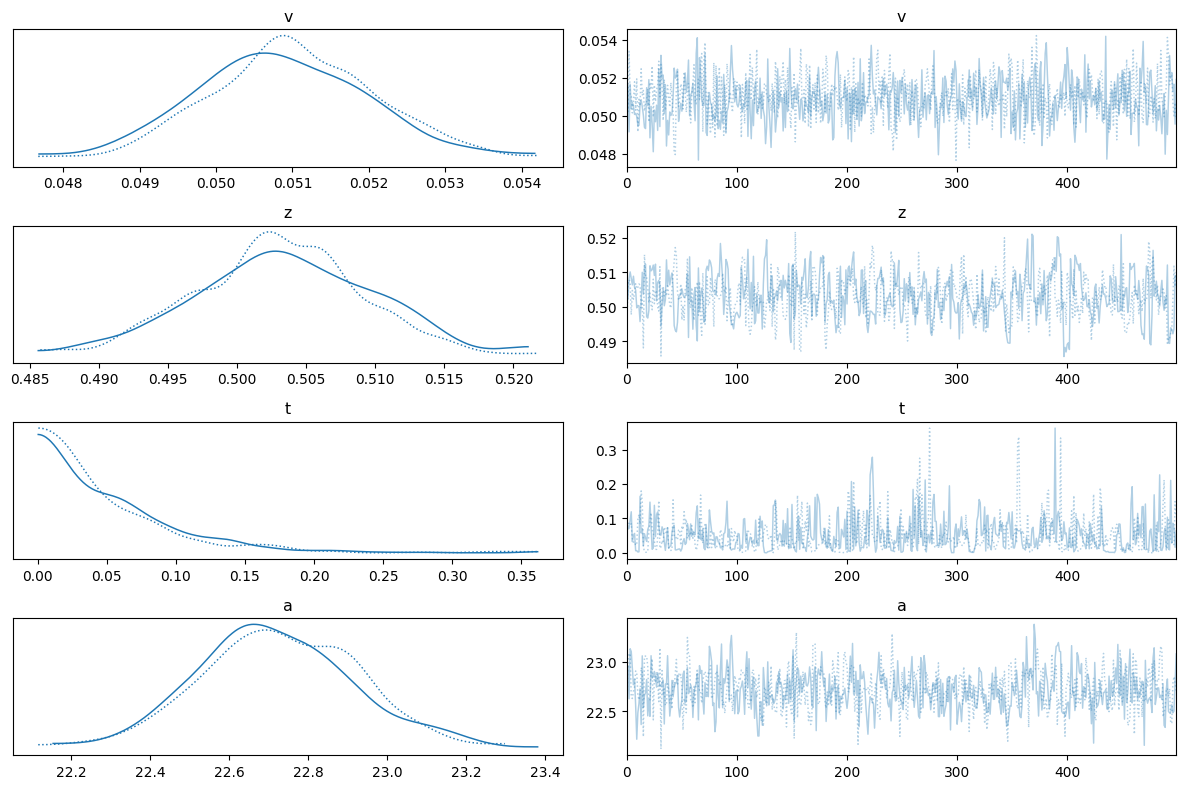

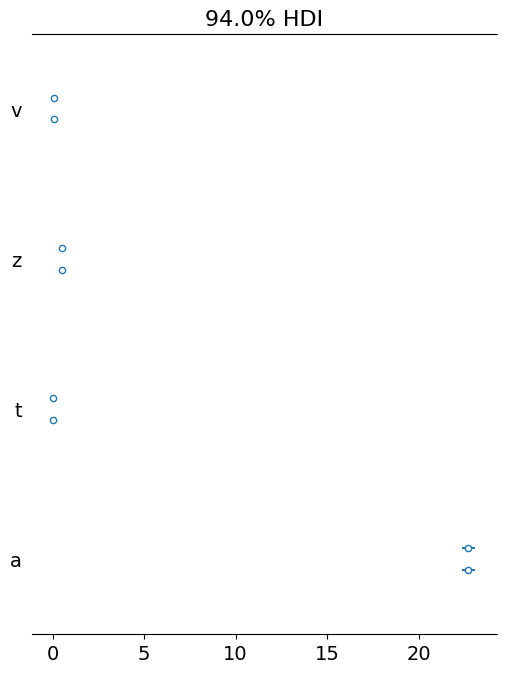

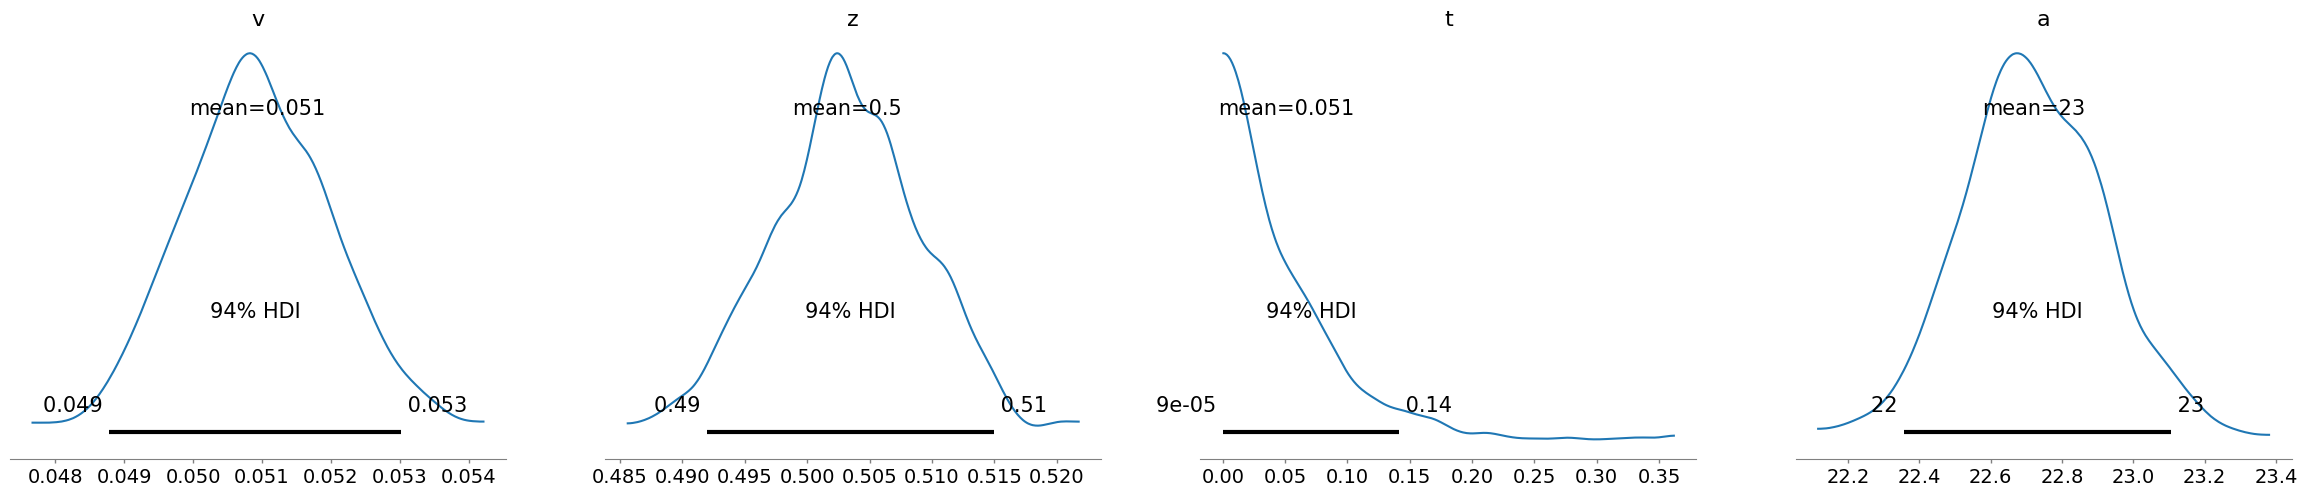

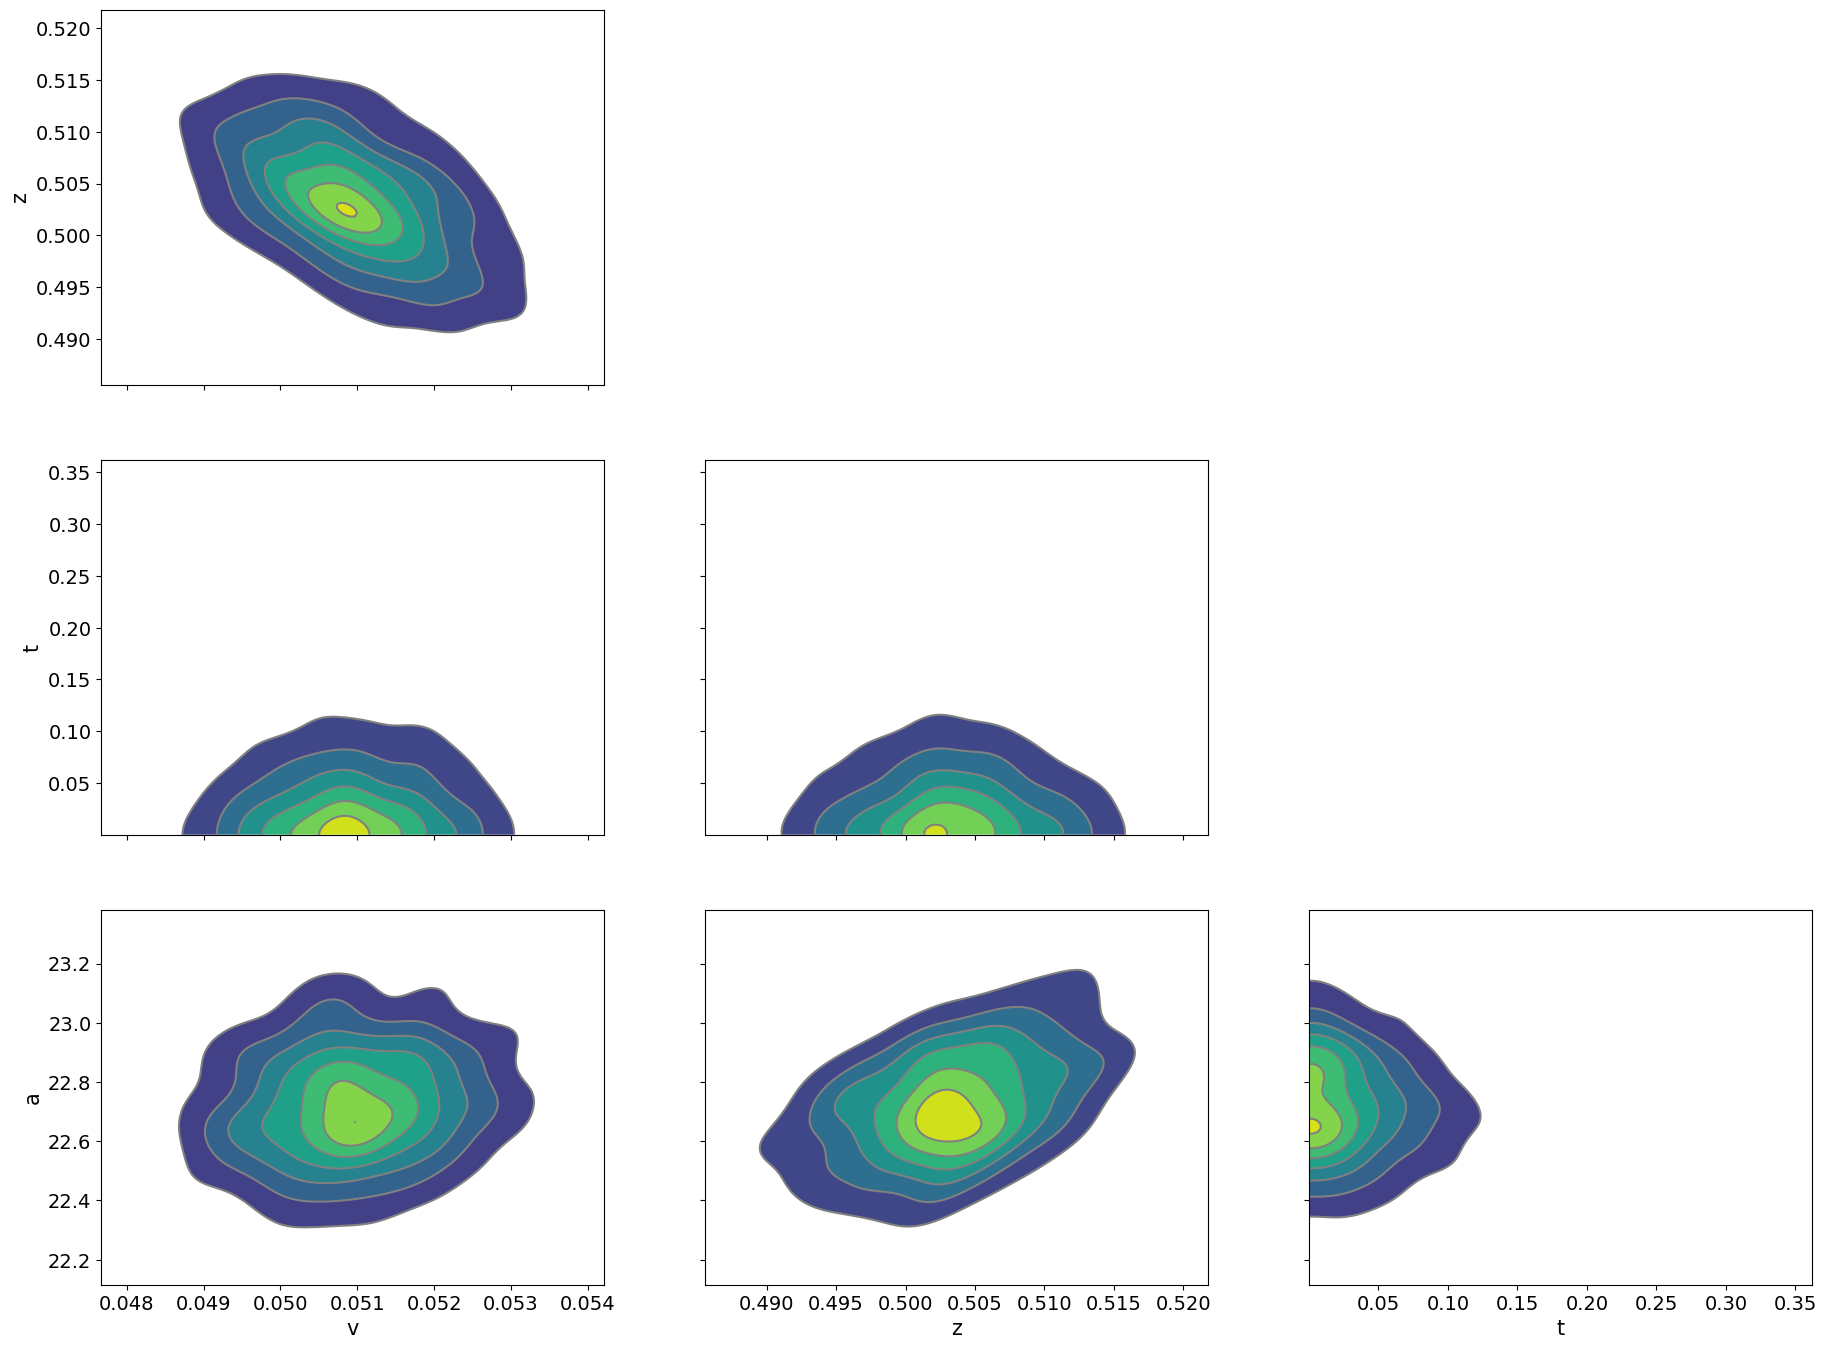

In [13]:
#Mandarin viz
az.plot_trace(
    infer_data_simple_ddm_model_mandarin,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

#trouble shooting code
constant_values = np.all(df_mandarin == df_mandarin.iloc[0], axis=0)
print(constant_values)
# Check for NaN values
nan_values = df_mandarin.isnull().any()
print(nan_values)

az.plot_forest(simple_ddm_model_mandarin.traces)
az.plot_posterior(simple_ddm_model_mandarin.traces)
az.plot_pair(simple_ddm_model_mandarin.traces, kind="kde")
simple_ddm_model_mandarin.loglik_kind

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(


rt          False
response    False
dtype: bool
rt          False
response    False
dtype: bool


'analytical'

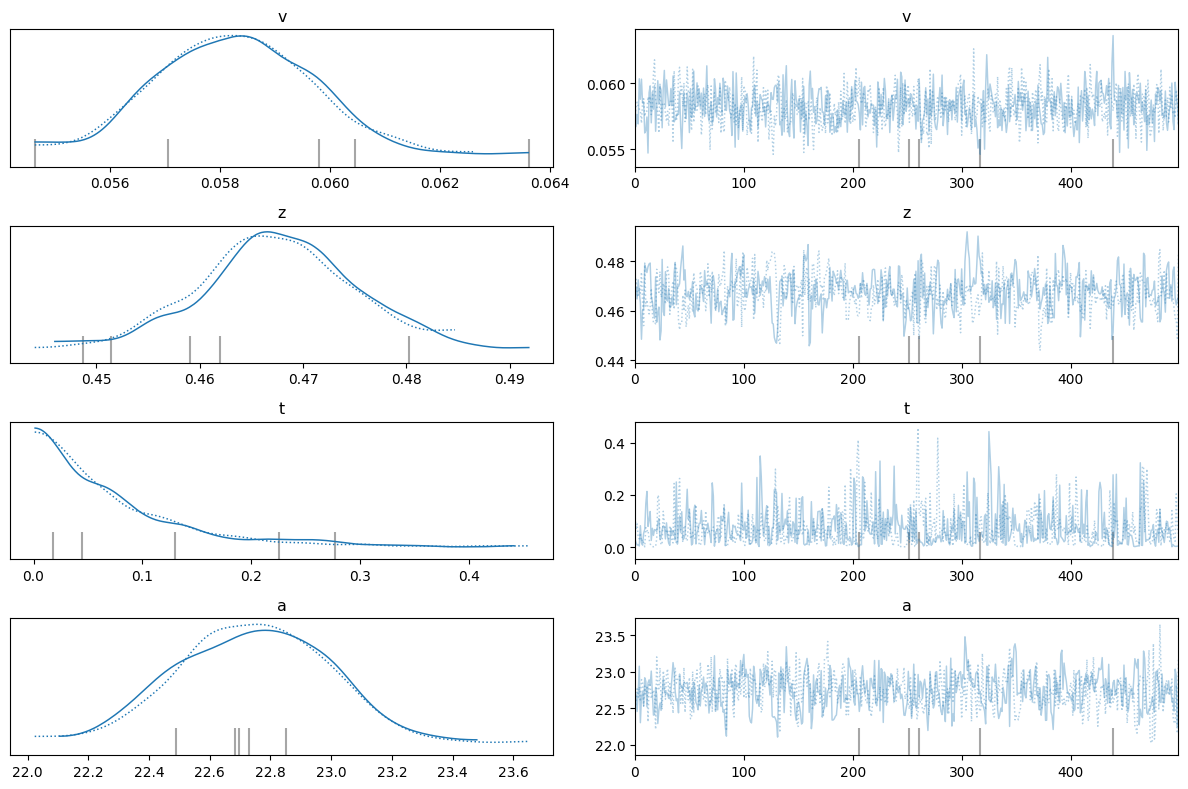

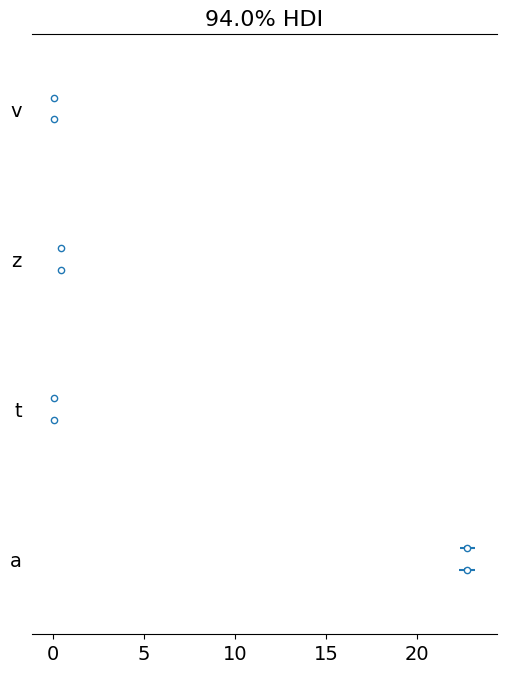

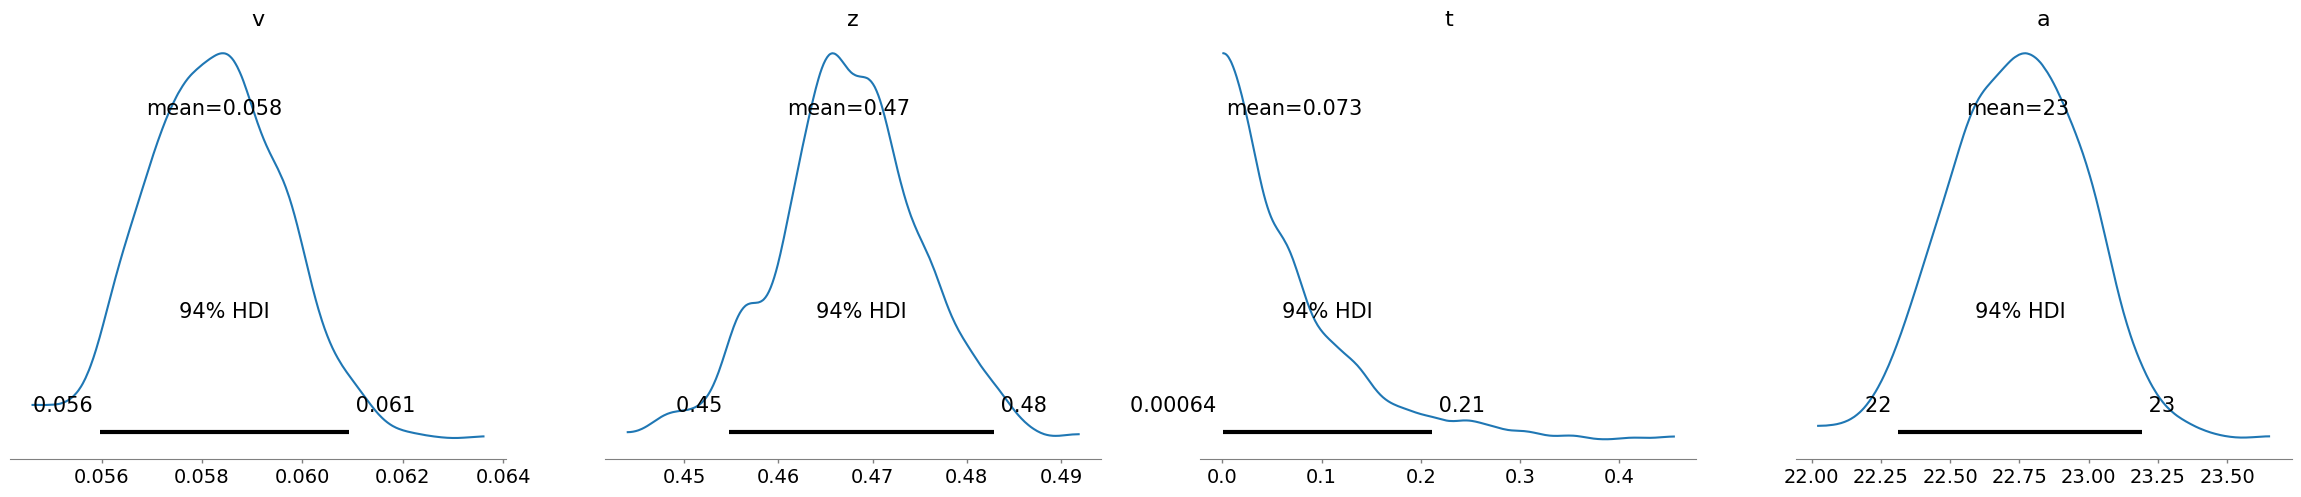

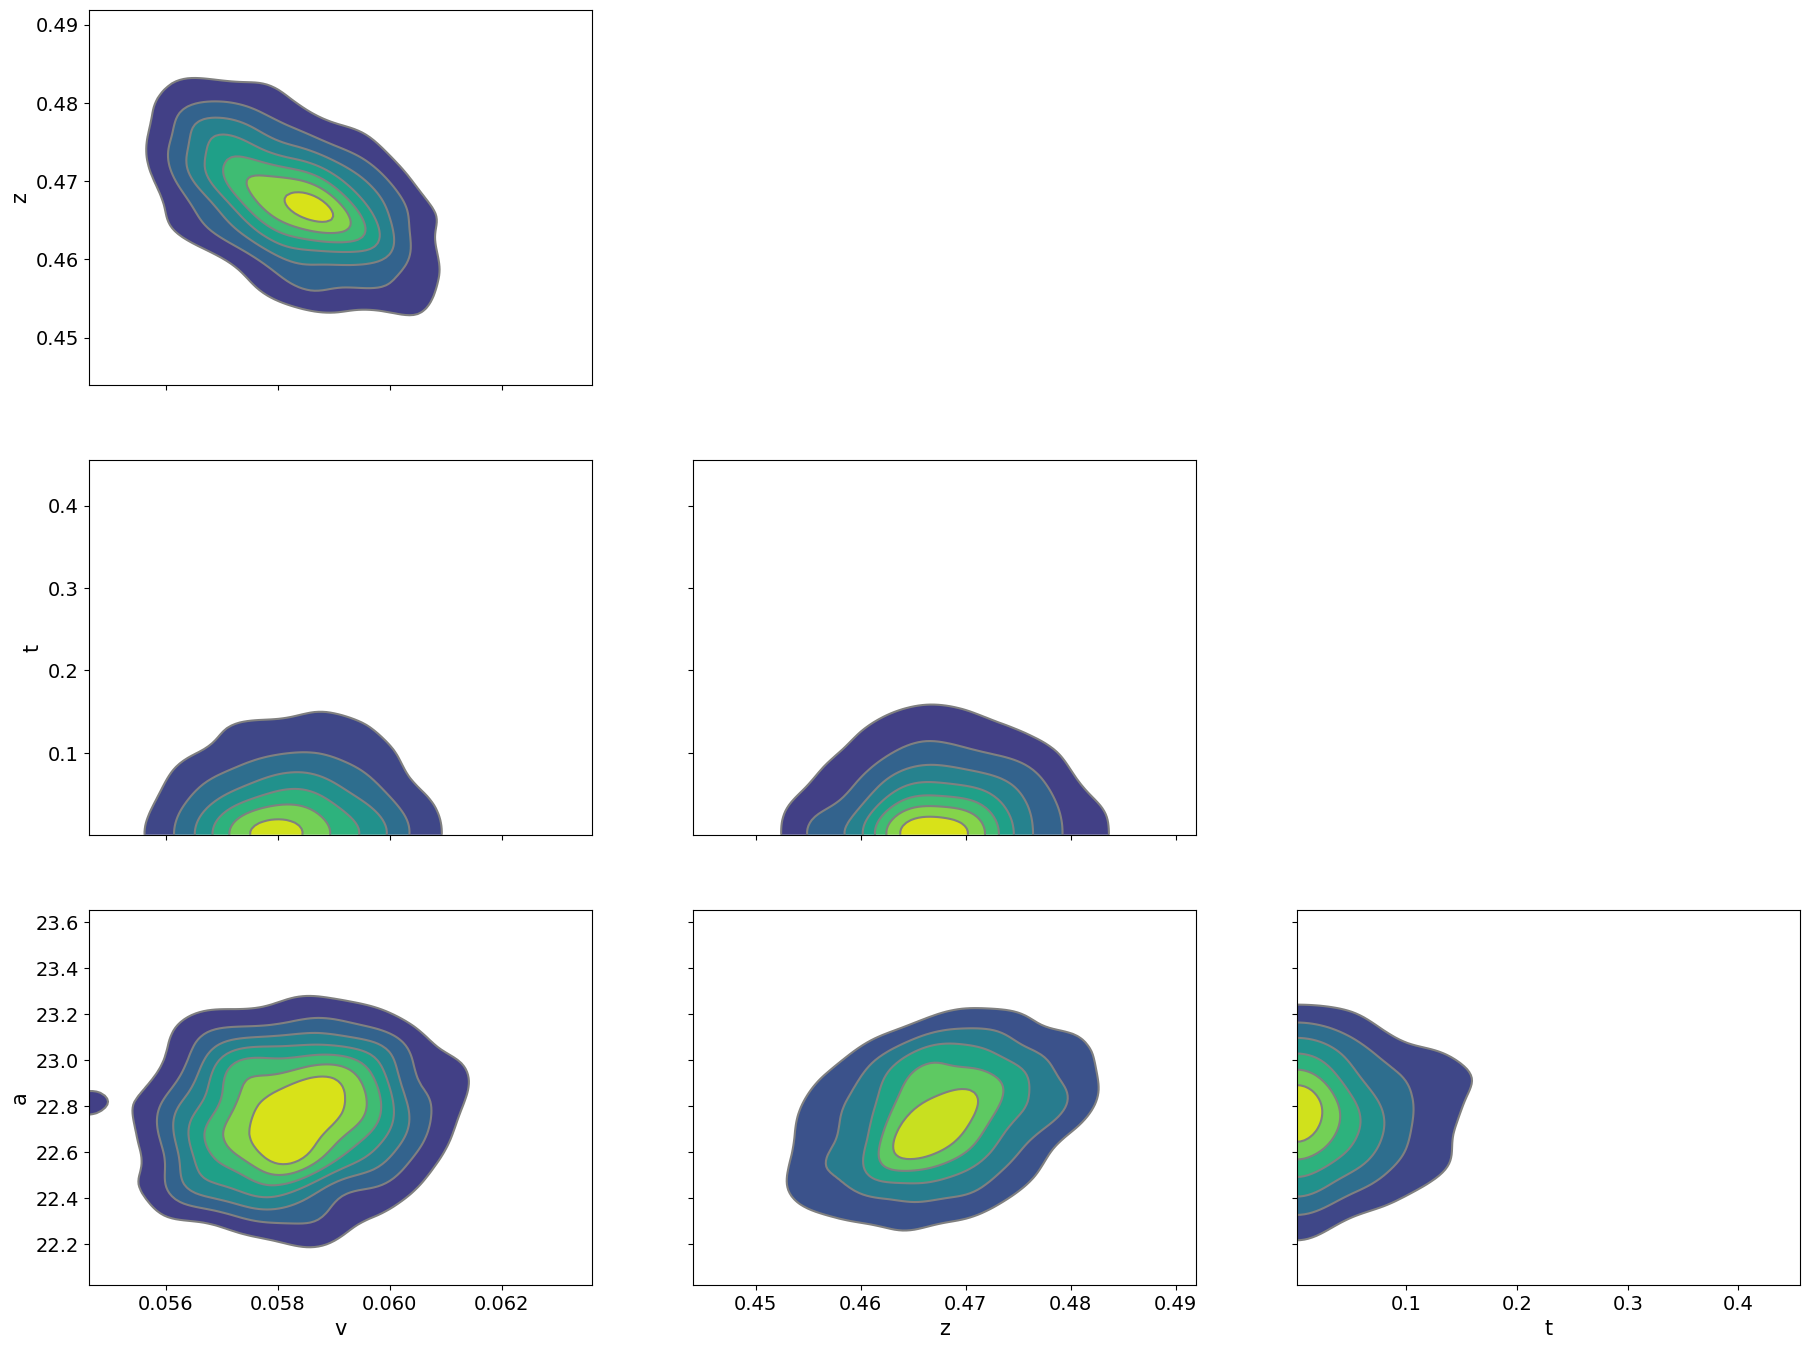

In [14]:
#japanese viz
az.plot_trace(
    infer_data_simple_ddm_model_japanese,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

constant_values = np.all(df_japanese == df_japanese.iloc[0], axis=0)
print(constant_values)
# Check for NaN values
nan_values = df_japanese.isnull().any()
print(nan_values)

az.plot_forest(simple_ddm_model_japanese.traces)
az.plot_posterior(simple_ddm_model_japanese.traces)
az.plot_pair(simple_ddm_model_japanese.traces, kind="kde")
simple_ddm_model_japanese.loglik_kind

#### Hierarchical model data
#### Mandarin Models



In [16]:
##Hierarchical data frames
#creating hierarchical dataframes
df['rt'] = df['Reaction.Time']
df['response'] = df['Answer_correct']
df['x'] = df['centered_beats']
df['y'] = df['centered_melody']
df['subject'] = df['Participant.Private.ID']
df['response'] = df['response'].replace({0: -1})

#create Mandarin df hierarchical
dfh_mandarin = df[df['Spreadsheet.Name'] == 'Mandarin']
dfh_mandarin = dfh_mandarin[['rt', 'response','x','y','subject']]

#create Mandarin df hierarchical
dfh_japanese = df[df['Spreadsheet.Name'] == 'japanese']
dfh_japanese = dfh_japanese[['rt', 'response','x','y','subject']]

print(dfh_mandarin.head())
print(dfh_japanese.head())

      rt  response         x         y  subject
0  318.0         1  0.649675  0.655506  9353724
1  369.0         1  0.649675  0.655506  9353724
2  339.0         1  0.649675  0.655506  9353724
3  609.0         1  0.649675  0.655506  9353724
4  450.0         1  0.649675  0.655506  9353724
         rt  response         x         y  subject
5196  835.0         1  0.649675  0.655506  9353724
5197  369.0         1  0.649675  0.655506  9353724
5198  297.0         1  0.649675  0.655506  9353724
5199  265.0         1  0.649675  0.655506  9353724
5200  341.0         1  0.649675  0.655506  9353724


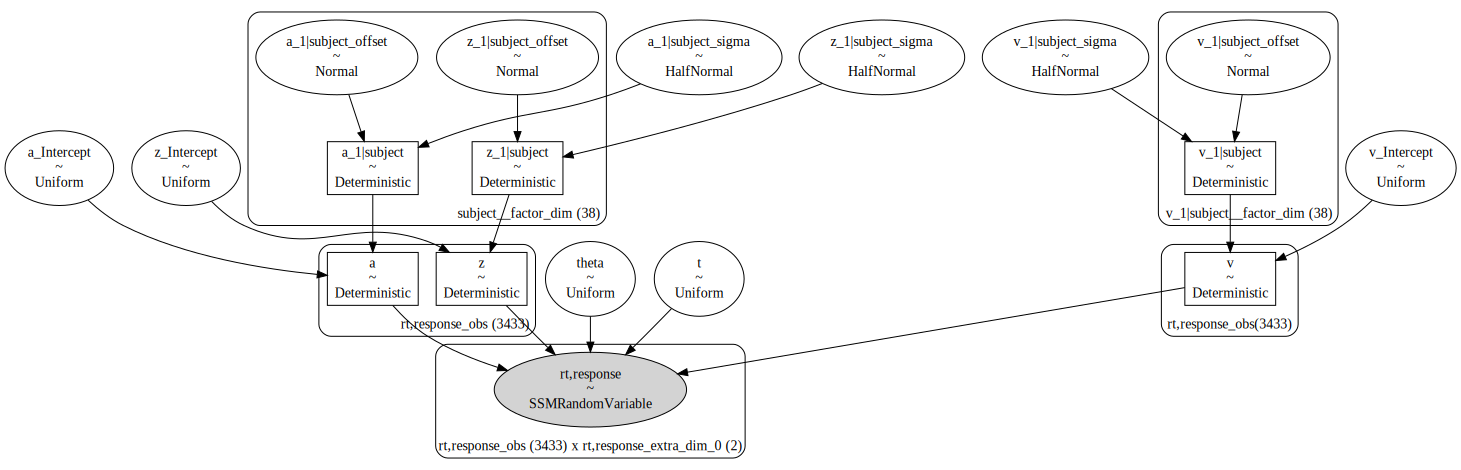

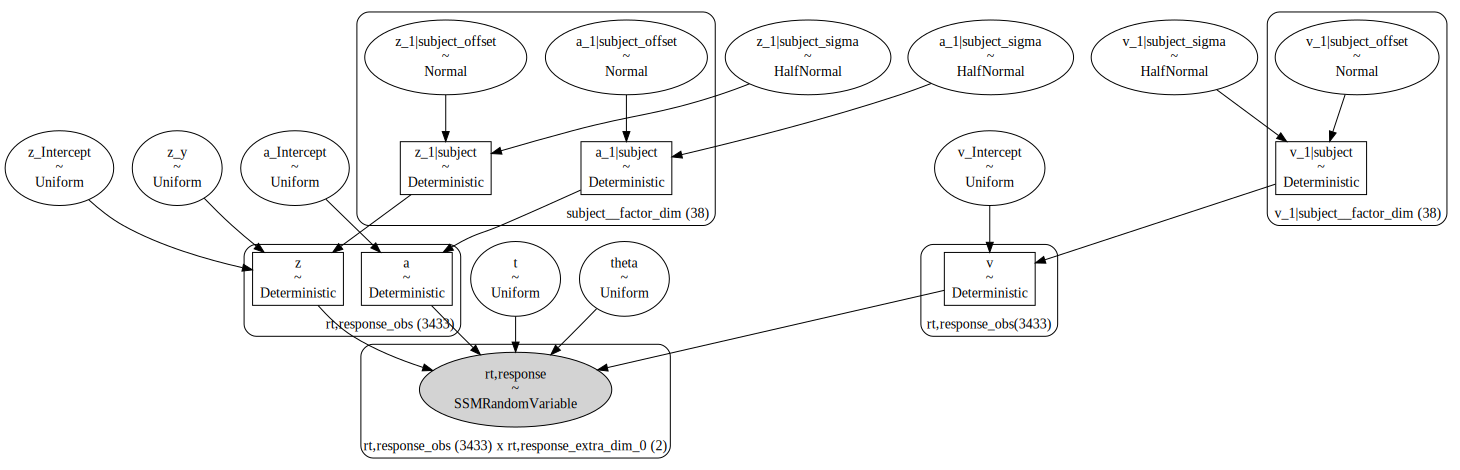

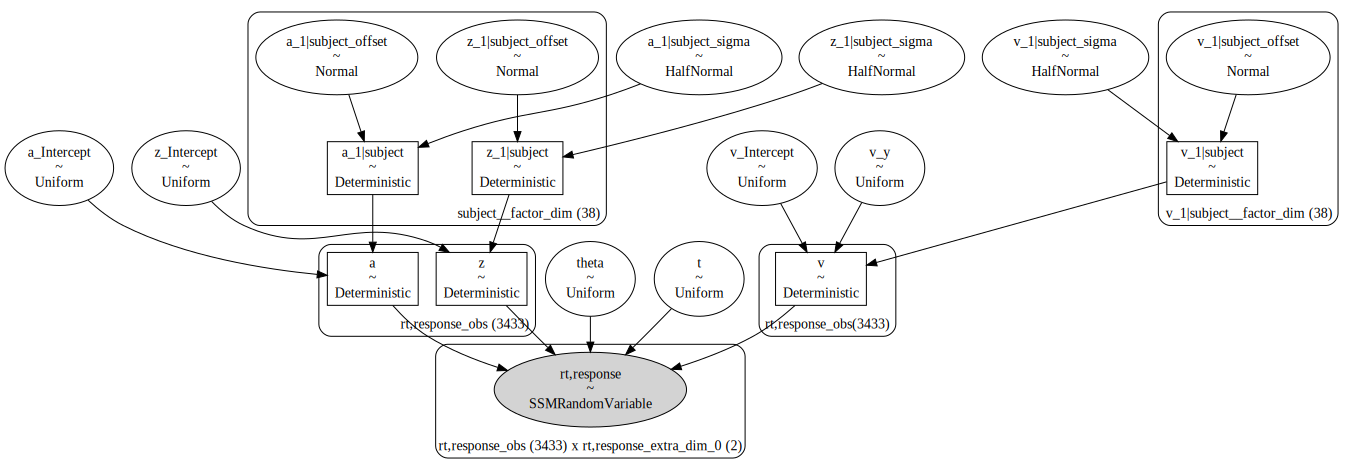

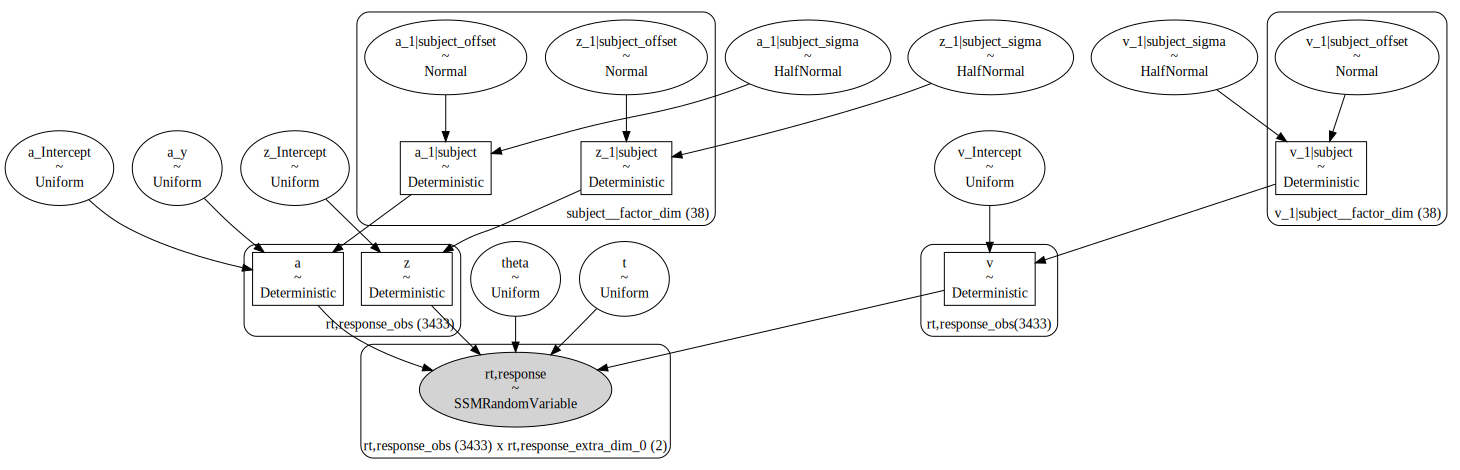

In [31]:
#all models mandarin
mandarin_base = hssm.HSSM(
    data=dfh_mandarin,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        }
    ],
)

mandarin_pitch_bias = hssm.HSSM(
    data=dfh_mandarin,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + y",
            "link": "identity",
        }
    ],
)

mandarin_pitch_drift = hssm.HSSM(
    data=dfh_mandarin,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + y",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) ",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        }
    ],
)

mandarin_pitch_threshold = hssm.HSSM(
    data=dfh_mandarin,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + y",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        }
    ],
)

display(mandarin_base.graph())
display(mandarin_pitch_bias.graph())
display(mandarin_pitch_drift.graph())
display(mandarin_pitch_threshold.graph())


In [32]:
#base model
config.update("jax_enable_x64", False)
mandarin_base.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [33]:
#pitch bias model
mandarin_pitch_bias.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [34]:
#pitch drift model
config.update("jax_enable_x64", False)
mandarin_pitch_drift.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [35]:
#pitch threshold model
config.update("jax_enable_x64", False)
mandarin_pitch_threshold.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [36]:
# Mandarin model comparison
base_bias = az.compare(
    {
    "base": mandarin_base.traces,
    "pitch bias (a)": mandarin_pitch_bias.traces,
    }
)
base_drift = az.compare(
    {
    "base": mandarin_base.traces,
    "pitch drift (a)": mandarin_pitch_drift.traces,
    }
)
base_threshold = az.compare(
    {
    "base": mandarin_base.traces,
    "pitch threshold (a)": mandarin_pitch_threshold.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated

In [37]:
print(base_bias)
print(base_drift)
print(base_threshold)

                rank       elpd_loo         p_loo    elpd_diff        weight  \
pitch bias (a)     0 -220672.087887  47851.153860     0.000000  1.000000e+00   
base               1 -226672.430473  21982.918616  6000.342586  1.221245e-15   

                        se        dse  warning scale  
pitch bias (a)  578.126406    0.00000     True   log  
base             12.427526  578.96974     True   log  
                 rank       elpd_loo         p_loo    elpd_diff  weight  \
pitch drift (a)     0 -220690.575971  65952.319203     0.000000     1.0   
base                1 -226672.430473  21982.918616  5981.854502     0.0   

                         se         dse  warning scale  
pitch drift (a)  562.641983    0.000000     True   log  
base              12.427526  563.502702     True   log  
                     rank       elpd_loo         p_loo  elpd_diff    weight  \
base                    0 -226672.430473  21982.918616   0.000000  0.798679   
pitch threshold (a)     1 -226734.81337

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

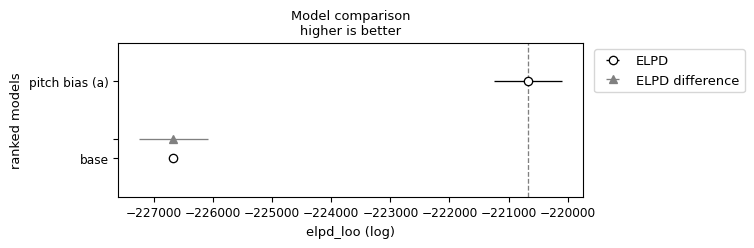

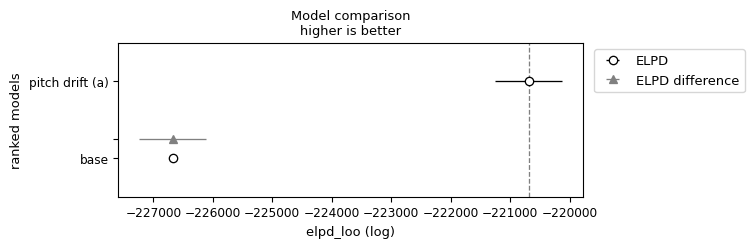

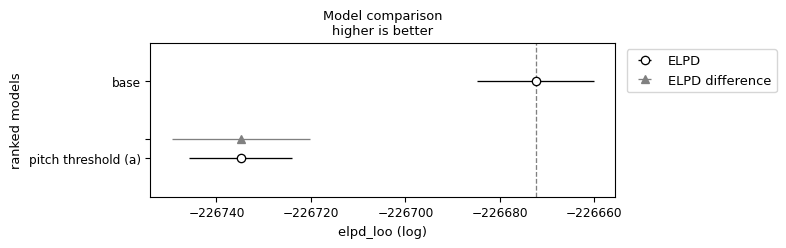

In [39]:
#plot comparison of model comparison
az.plot_compare(base_bias)
az.plot_compare(base_drift)
az.plot_compare(base_threshold)

In [40]:
bias_drift = az.compare(
    {
    "pitch bias (a)": mandarin_pitch_bias.traces,
    "pitch drift (a)": mandarin_pitch_drift.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [41]:
print(bias_drift)

                 rank       elpd_loo         p_loo  elpd_diff   weight  \
pitch bias (a)      0 -220672.087887  47851.153860   0.000000  0.38941   
pitch drift (a)     1 -220690.575971  65952.319203  18.488084  0.61059   

                         se         dse  warning scale  
pitch bias (a)   578.126406    0.000000     True   log  
pitch drift (a)  562.641983  815.787151     True   log  


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

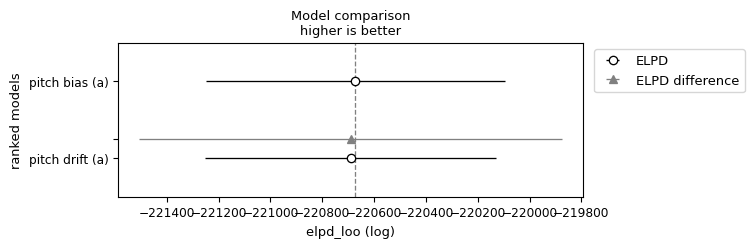

In [43]:
az.plot_compare(bias_drift)

####Japanese Models

In [ ]:
japanese_base = hssm.HSSM(
    data=dfh_japanese,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        }
    ],
)

japanese_rhythm_bias = hssm.HSSM(
    data=dfh_japanese,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x",
            "link": "identity",
        }
    ],
)

japanese_rhythm_drift = hssm.HSSM(
    data=dfh_japanese,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) ",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        }
    ],
)

japanese_rhythm_threshold = hssm.HSSM(
    data=dfh_japanese,
    model="angle",
    loglik_kind = "approx_differentiable",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject)",
            "link": "identity",
        }
    ],
)

display(japanese_base.graph())
display(japanese_rhythm_bias.graph())
display(japanese_rhythm_drift.graph())
display(japanese_rhythm_threshold.graph())

In [ ]:
#base model
config.update("jax_enable_x64", False)
japanese_base.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

In [ ]:
#rhythm bias model
japanese_rhythm_bias.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

In [ ]:
#rhythm drift model
config.update("jax_enable_x64", False)
japanese_rhythm_drift.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
)

In [ ]:
#rhythm threshold model
config.update("jax_enable_x64", False)
japanese_rhythm_threshold.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=True),
)

In [ ]:
# japanese model comparison
j_base_bias = az.compare(
    {
    "base": japanese_base.traces,
    "pitch bias (a)": japanese_rhythm_bias.traces,
    }
)
j_base_drift = az.compare(
    {
    "base": japanese_base.traces,
    "pitch drift (a)": japanese_rhythm_drift.traces,
    }
)
j_base_threshold = az.compare(
    {
    "base": japanese_base.traces,
    "pitch threshold (a)": japanese_rhythm_threshold.traces,
    }
)

In [ ]:
print(j_base_bias)
print(j_base_drift)
print(j_base_threshold)

In [ ]:
#plot comparison of model comparison
az.plot_compare(j_base_bias)
az.plot_compare(j_base_drift)
az.plot_compare(j_base_threshold)